In [39]:
# Imports, as always...
from random import choice
from math import log, sqrt
from functools import reduce
from itertools import product
from tqdm.notebook import tqdm
import numpy as np

from qiskit import __version__ as qiskit_version
from qiskit_aer import __version__ as qiskit_aer_version

from qiskit import execute
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, UnitarySimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.states import Statevector
from qiskit.visualization import plot_bloch_multivector

from scripts.dataset import generate_dataset, expand_into_datasets

In [2]:
# Package versions (ignoring packages that obviously won't be a problem).
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit_aer', qiskit_aer_version), ('numpy', np.__version__)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit     : 0.45.0
qiskit_aer : 0.14.1
numpy      : 1.22.3


# Sewing Local Inversions

In this notebook, we implement the method due to [Huang et al. (2024)](https://arxiv.org/abs/2401.10095) for learning (general) shallow quantum circuits (SQCs) by first finding a set of local inversions $\{V_i\}_{i=1,\dots,n}$ for each qubit $i$ and then "sewing" them together. The learning algorithms are fully classical and broadly efficient (in that they are polynomial complexity).

In the following,
- $\text{stab}_1=\{|0\rangle,|1\rangle,|+\rangle,|-\rangle,|y_+\rangle,|y_-\rangle\}$ is the set of single-qubit stabiliser states.

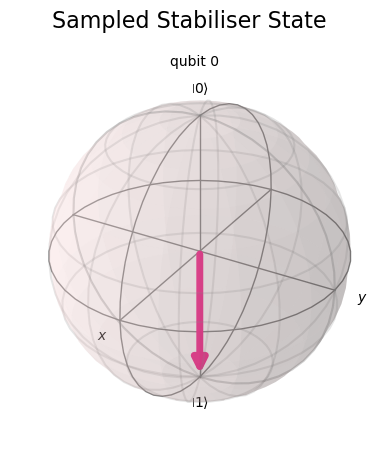

In [3]:
# Function to randomly generate a single-qubit stabiliser state from the above set.
def generate_random_stab_1():
    # List of possible states (by their labelling in Qiskit)
    state_labels = ['0', '1', '+', '-', 'r', 'l']

    # Generate a state vector for a randomly chosen label.
    return Statevector.from_label(choice(state_labels))

# Demo.
random_stab_1 = generate_random_stab_1()
plot_bloch_multivector(random_stab_1, title='Sampled Stabiliser State')

## Generate the SQC $U$

Obviously, we'll need to generate an unknown $n$-qubit unitary $U$ that is "shallow". In the context of this work, "shallow" is taken to mean of a constant depth $\mathcal{O}(1)$.

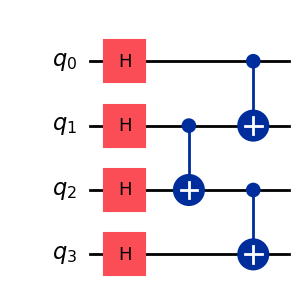

In [4]:
# For now, let's just arbitrarily define a unitary to work with.
# Why not use the one from the tutorial (see resources).
U = QuantumCircuit(4)
U.h(0), U.h(1), U.h(2), U.h(3)
U.cx(1, 2), U.cx(0, 1), U.cx(2, 3)

U.draw('mpl', style='iqp')

## Generating a Dataset

The learning algorithm uses a randomised measurement dataset of size $N$ for the unknown $n$-qubit unitary $U$, which takes the form as given in definition 8:
$$
\mathcal{T}_U(N)=\bigg\{|\psi_\ell\rangle=\bigotimes^n_{i=1}|\psi_{\ell,i}\rangle,|\phi_\ell\rangle=\bigotimes^n_{i=1}|\phi_{\ell,i}\rangle\bigg\}^N_{\ell=1}\ .
$$

Each sample is obtained from one experiment as follows:
1. Sample an input state $|\psi_\ell\rangle=\bigotimes^n_{i=1}|\psi_{\ell,i}\rangle$, which is a product state consisting of uniformly random single-qubit stabiliser states in $\text{stab}_1$.
2. Apply the unknown unitary $U$ to $|\psi_\ell\rangle$.
3. Measure every qubit of $U|\psi_\ell\rangle$ under a random Pauli basis, thus collapsing it to an output state $|\phi_\ell\rangle=\bigotimes^n_{i=1}|\phi_{\ell,i}\rangle$, where $|\phi_{\ell,i}\rangle$ is, again, in $\text{stab}_1$.

After $N$ queries to $U$ in this way, we will have constructed a dataset $\mathcal{T}_U(N)$ with $N$ samples. This is said to be able to be represented efficiently on a classical computer with $\mathcal{O}(Nn)$ bits.

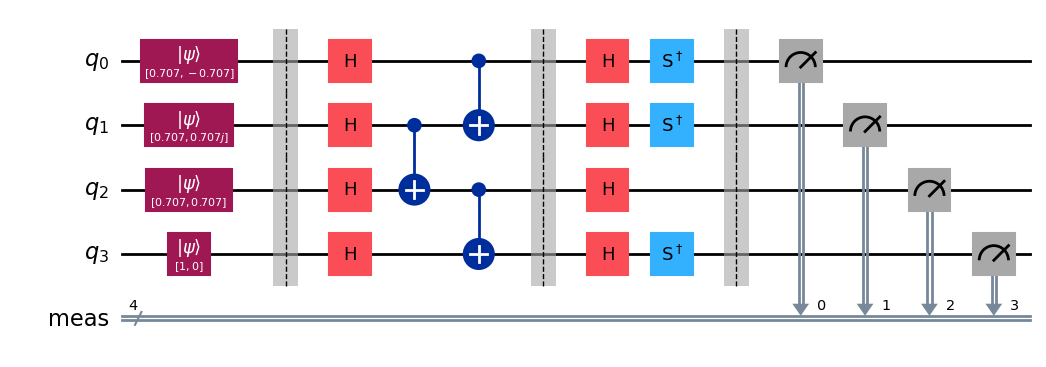

In [5]:
# Function to build a circuit implementing the experiment given in Huang et al. (2024)'s dataset procedure.
def build_experiment_circuit(U):
    # Instantiate a new circuit.
    circuit = QuantumCircuit(U.num_qubits)
    
    # We initialise each of the qubits to specify the input state (as a product of stable states).
    input_states = []
    for i in range(circuit.num_qubits):
        # Choose and keep track of the initialised state.
        init_state = generate_random_stab_1()
        input_states.append(init_state)
        
        # Prepare the qubit.
        circuit.initialize(init_state, i)
        
    # Barrier for clarity.
    circuit.barrier()
        
    # Create a copy of the given unitary so that we may add to the circuit.
    U_copy = U.copy()
    circuit = circuit.compose(U_copy)
    
    # Barrier for clarity.
    circuit.barrier()
    
    # For each qubit, we randomly select a Pauli basis to measure it in (to collapse them to stabiliser states).
    output_bases = []
    for i in range(circuit.num_qubits):
        # Choose a Pauli basis, and keep track of it.
        j = choice([0, 1, 2])
        output_bases.append(j)
        
        # Measuring in the X basis.
        if j == 1:
            circuit.h(i)
            continue
        
        # Measuring in the Y basis.
        elif j == 2:
            circuit.h(i), circuit.sdg(i)
            continue
            
        # Measuring in the Z basis -- no projection needed.
        else:
            continue
        
    # Measure all qubits. A barrier is placed automatically here.
    circuit.measure_all()
    
    # Return the circuit, the input states, and the output bases.
    return circuit, input_states, output_bases

# Demo.
experiment_circuit, input_states, output_bases = build_experiment_circuit(U)
experiment_circuit.draw('mpl', style='iqp')

In [6]:
# Instantiate a backend.
backend = AerSimulator()
job = execute(experiment_circuit, backend=backend, shots=1)
measurement_outcomes = list(job.result().get_counts(experiment_circuit).keys())[0]
measurement_outcomes

'0111'

In [7]:
# Function to translate the measurement outcome to the corresponding output states.
def measurements_to_state_vectors(output_bases, measurement_outcomes):
    # The stabiliser states.
    state_labels = ['0', '1', '+', '-', 'r', 'l']
    
    output_states = []
    for basis, measurement in zip(output_bases, measurement_outcomes):
        # Now our indexing scheme pays off.
        output_states.append(Statevector.from_label(state_labels[2 * basis + int(measurement)]))
        
    return output_states

# Demo.
state_outcomes = measurements_to_state_vectors(output_bases, measurement_outcomes)
state_outcomes

[Statevector([0.70710678+0.j        , 0.        +0.70710678j],
             dims=(2,)),
 Statevector([0.70710678+0.j        , 0.        -0.70710678j],
             dims=(2,)),
 Statevector([ 0.70710678+0.j, -0.70710678+0.j],
             dims=(2,)),
 Statevector([0.70710678+0.j        , 0.        -0.70710678j],
             dims=(2,))]

In [8]:
# Helper function to combine state vectors into a single product state vector.
def big_tensor(state_vector_list):
    return reduce(lambda x, y : x ^ y, state_vector_list)

# Convert the list of input states and the list of output states into single product states.
input_states = big_tensor(input_states)
state_outcomes = big_tensor(state_outcomes)

input_states, state_outcomes

(Statevector([ 0.35355339+0.j        ,  0.        +0.j        ,
               0.35355339+0.j        ,  0.        +0.j        ,
               0.        +0.35355339j,  0.        +0.j        ,
               0.        +0.35355339j,  0.        +0.j        ,
              -0.35355339+0.j        , -0.        +0.j        ,
              -0.35355339+0.j        , -0.        +0.j        ,
               0.        -0.35355339j,  0.        +0.j        ,
               0.        -0.35355339j,  0.        +0.j        ],
             dims=(2, 2, 2, 2)),
 Statevector([ 0.25+0.j  ,  0.  -0.25j, -0.25+0.j  ,  0.  +0.25j,
               0.  -0.25j, -0.25-0.j  ,  0.  +0.25j,  0.25+0.j  ,
               0.  +0.25j,  0.25+0.j  ,  0.  -0.25j, -0.25+0.j  ,
               0.25+0.j  ,  0.  -0.25j, -0.25+0.j  ,  0.  +0.25j],
             dims=(2, 2, 2, 2)))

In [9]:
# The full dataset generation procedure.
def generate_dataset(U, N, product_states=True):
    # Instantiate a backend simulator and dataset list.
    backend = AerSimulator()
    dataset = []
    
    # Running the experiment N times to produce a dataset of N pairs.
    for _ in tqdm(range(N), desc='Generating dataset'):
        # Set up the experiment.
        circuit, input_states, output_bases = build_experiment_circuit(U)
        
        # Execute the circuit (once) and note the measurement outcome string.
        job = execute(circuit, backend=backend, shots=1)
        measurement_outcomes = list(job.result().get_counts(circuit).keys())[0]  
        
        # Translate the measurement outcome string to the corresponding state vector.
        state_outcomes = measurements_to_state_vectors(output_bases, measurement_outcomes)
        
        if product_states:
            # Covert the state lists into product states.
            input_states = big_tensor(input_states)
            state_outcomes = big_tensor(state_outcomes)
            
        # Append to the dataset.
        dataset.append([input_states, state_outcomes])
        
    return dataset

In [55]:
# Generating a dataset.
dataset = generate_dataset(U, N=5000, product_states=False)

Generating dataset:   0%|          | 0/5000 [00:00<?, ?it/s]

Lemma 12 shows how we can reuse the randomised measurement dataset $\mathcal{T}_U(N)$ to create the datasets needed to learn approximate Heisenberg-evolved Pauli observables: we can create $3n$ datasets $\mathcal{T}_{U^\dag P_iU}(N)$, for each Pauli observable $P\in\{X,Y,Z\}$ and each qubit $i$,
$$
\mathcal{T}_{U^\dag P_iU}(N):=\Bigg\{|\psi_\ell\rangle=\bigotimes_{j=1}^n|\psi_{\ell,j}\rangle,v_\ell^{U^\dag P_iU}\Bigg\}^N_{\ell=1}\ ,
$$
where $|\psi_{\ell,i}\rangle$ is sampled uniformly and independently from $\text{stab}_1$, and $v_\ell^{U^\dag P_iU}$ with $\mathbb{E}[v_\ell^{U^\dag P_iU}]=\langle\psi_\ell|U^\dag P_iU|\psi_\ell\rangle$ and $|v_\ell^{U^\dag P_iU}|=\mathcal{O}(1)$.

To produce these datasets, we define the output $v_\ell^{U^\dag P_iU}:=3\langle\phi_{\ell,i}|P|\phi_{\ell,i}\rangle$ $\forall P,i$.

In [13]:
# Reuse a given classical dataset to create 3n datasets to be used for learning approximate Heisenberg-evolved Pauli observables.
def expand_into_datasets(dataset):
    # This assumes the dataset does NOT consist of product states but instead arrays of qubits. It'll be easier this way, trust me.
    
    # We will store each of the 3n datasets as values in a dictionary, indexed by its Pauli basis P and qubit i (i.e. tuple indexing).
    datasets = {}
    
    # Let's have the incoming dataset as a numpy array.
    dataset = np.array(dataset)
    
    # Defining the Pauli bases.
    X, Y, Z = np.array([[0, 1], [1, 0]]), np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]])
    pauli_bases = [X, Y, Z]
    
    # Loop over all P and all i.
    for i in tqdm(range(dataset.shape[2]), desc='Expanding dataset'):
        for P in range(3):
            # Instantiate the new dataset array.
            datasets[(P, i)] = []
            
            # Loop over all output samples in the dataset.
            for psi_ell, phi_ell in dataset:
                phi_i = phi_ell[i]
                
                # Compute the new output as per Lemma 12 and add to the appropriate dataset.
                datasets[(P, i)].append((psi_ell, 3 * (phi_i.T @ pauli_bases[P] @ phi_i))) 
                
    return datasets

In [56]:
expanded_dataset = expand_into_datasets(dataset)

Expanding dataset:   0%|          | 0/4 [00:00<?, ?it/s]

## Learning Using Local Inversions

By theorem 5, we can (probably) learn an $n$-qubit quantum channel $\hat\mathcal{E}$ that can be implemented by a constant-depth quantum circuit over $2n$ qubits such that $\|\hat\mathcal{E}-\mathcal{U}\|_\diamond\leq\varepsilon$, given an unknown $n$-qubit unitary $U$ generated by a constant-depth circuit over any two-qubit gates in $\text{SU}(4)$ with an arbitrary number of ancilla qubits. To do this, we require a dataset $\mathcal{T}_U(N)$ of size $N=\mathcal{O}((n/\varepsilon)^2\log(n/\delta))$.

Considering the implementation (remark 1), $\hat\mathcal{E}$ is the reduced channel $\mathcal{E}_{\leq n}^{\hat V}$ of the constant-depth $2n$-qubit circuit $\hat V$ on the first $n$ qubits.

In [15]:
# Hyperparamters.
eps = 1e-2
delta = 1e-2

# Required dataset size.
multiplier = 1
N = round(multiplier * (U.num_qubits / eps) ** 2 * log(U.num_qubits / delta))

print(f'Dataset of size N = {N:,} required.')

Dataset of size N = 958,634 required.


### Overview of the learning algorithm

Corollary 2 gives a statement for local inversion from Heisenberg-evolved Pauli observables: if $V_i$ satisfy 
$$
\sum_{P\in\{X,Y,Z\}}\|V_i^\dag U^\dag P_iUV_i-P_i\|_\infty\leq\varepsilon\ ,
$$
 where $P_i$ acts as $P$ on qubit $i$, then $V_i$ is a strong $\varepsilon$-approximate local inversion of $U$ on the $i$-th qubit. Hence, instead of learning $U$, we are considering learning $n$ local inversion unitaries $V_1,\dots,V_n$ -- the idea being that finding a $V_i$ that evolves $U^\dag P_iU$ approximately back to $P_i$ is much simpler than finding an entire $n$-qubit inversion altogether.
 
Having found the $n$-qubit unitaries $V_1,\dots,V_n$, we define the $2n$-qubit "sewed" unitary to be
$$
U_\text{sew}(V_1,\dots,V_n):=S\Bigg[\prod_{i=1}^n\Big(V_i^{(1)}\Big)S_i\Big(V_i^{(1)}\Big)^\dag\Bigg]\ ,
$$
where $V_i^{(1)}$ applies $V_i$ to the first $n$ qubits, and $S_i$ is the swap operator for the $i$-th qubit between the two sets of $n$ qubits (i.e. qubits $i$ and $i+n$), and $S$ is the swap operator for all $n$ qubits. Sewing order is arbitrary.

### The direct sewing alternative

An alternative (and computationally-simpler) method is to directly sew the Heisenberg-evolved Pauli observables into a $2n$-qubit unitary (instead of $n$ qubits) that approximates $U\otimes U^\dag$.

An $n$-qubit observable $O_{i,P}$ is an $\varepsilon$-approximate Heisenberg-evolved Pauli observable $P$ on qubit $i$ under $U$ if 
$$
\|O_{i,P}-U^\dag P_iU\|_\infty\leq\varepsilon\ .
$$

Given a set of $3n$ Heisenberg-evolved Pauli observables $O_{i,P}$ $\forall i\in\{1,\dots,n\},P\in\{X,Y,Z\}$, we define the $2n$-qubit unitary to be
$$
U_\text{sew}(\{O_{i,P}\}_{i,P}):=S\prod_{i=1}^n\Bigg[\text{Proj}_U\Bigg(\frac{1}{2}I\otimes I+\frac{1}{2}\sum_{P\in\{X,Y,Z\}}O_{i,P}\otimes P_i\Bigg)\Bigg]\ ,
$$ 
where $\text{Proj}_U(A):=\text{argmin}_B\|A-B\|_\infty$ for $B$ a unitary, which is shown to be equivalent to $\text{Proj}_U(A)=UV^\dag$ in Lemma 8 (and thus making this computationally-efficient for a classical computer). Again, sewing order is arbitrary.

### Learning approximate Heisenberg-evolved Pauli observables 

Given an $n$-qubit observable $O$, we define $\text{supp}(O)$ to be the set of qubits that $O$ acts on. The *learnt* observable $\hat O$ has the property that it only acts on qubits that $O$ acts on, hence $\text{supp}(\hat O)\subseteq\text{supp}(O)$. We will also define $|O|:=|\text{supp}(O)|$ to be the number of qubits $O$ acts on. 

By Lemma 10, the learnt observable $\hat{O}$ follows the form
$$
\begin{split}
\hat{\alpha}_P:=&\frac{3^{|P|}}{N}\sum_{\ell=1}^Nv_\ell\langle\psi_\ell|P|\psi_\ell\rangle,\ \forall P\in\{I,X,Y,Z\}^{\otimes n}:|P|\leq k,\\
\hat{\beta}_P:=&
\begin{cases}
\hat{\alpha}_P\phantom{xxx}&\text{if}\ |\hat{\alpha}_P|\geq0.5\varepsilon/(2\sqrt{2})^k\\
0&\text{otherwise}
\end{cases}\\
\hat{O}:=&\sum_{P\in\{I,X,Y,Z\}^{\otimes n}:|P|\geq k}\hat{\beta}_PP\ ,
\end{split}
$$
where we are learning $O$, an $n$-qubit observable with $\|O\|_\infty\leq1$ acting on an unknown set of $k$ qubits. Under my interpretation, $|P|$ simply refers to the number of non-identity Pauli matrices (e.g. $|XIXYXZIZ|=6$). 

Combining Lemma 12 for constructing $\mathcal{T}_{U^\dag P_iU}(N)$ $\forall P,i$ from $\mathcal{T}_U(N)$, and Lemma 10 for learning few-body observables with unknown supports, we can learn $\hat{O}_{i,P}$ $\forall i,P$ with a dataset of size $N=\mathcal{O}((n/\varepsilon)^2\log(n/\delta))$ for constant $\varepsilon=\mathcal{O}(1)$.

Lemma 9 proves the form of the sewed Heisenberg-evolved Pauli observables to yield
$$
\|\mathcal{U}_\text{sew}(\{\hat{O}_{i,P}\}_{i,P})-\mathcal{U}\otimes\mathcal{U}^\dag\|_\diamond\leq\varepsilon\ .
$$

Thus, we can define an $n$-qubit channel $\hat\mathcal{E}$ by
$$
\hat\mathcal{E}(\rho):=\text{tr}_{>n}(\mathcal{U}_\text{sew}(\{\hat{O}_{i,P}\}_{i,P})(\rho\otimes|0^n\rangle\langle0^n|))\ ,
$$
which can be implemented as a constant-depth quantum circuit over $2n$ qubits. Since we are using approximations with a failure probability $\delta$, we have $\|\hat\mathcal{E}-\mathcal{U}\|_\diamond\leq\varepsilon$ with probability at least $1-\delta$ (first part of theorem 5).

### How can we know $k$?

So, we are learning the $3n$ $n$-qubit operators $\{\hat{O}_{i,P}\}_{i,P}$, each of which acts (approximately) as the Pauli operator $P$ on qubit $i$ under $U$. So how many qubits $k$ does each $O_{i,P}$ act on? 

Since Pauli operators are single-qubit operators, $k$ really ought to be $1$. However, the "under $U$" qualifier complicates things; being "under $U$" speaks to the fact that $O_{i,P}\approx U^\dag P_iU$, and so $k$ should actually be all $n$ qubits, since $U$ acts on all $n$. In another way of thinking, we aren't doing anything by $U^\dag U$, so $U^\dag P_iU$ should really only "act" on the qubits to which qubit $i$ is influential -- in other words, maybe $k$ should only be the size of the lightcone of qubit $i$ in $U$. Discussion of lightcones in the general learning setting is virtually absent. To make things worse still, Huang et al. (2024) give that $k:|\text{supp}(\hat{O})|=|A(i)|=O(1)$, which is to say that $k$ is the size of the support (which is unknown, by admission, for this algorithm), and that the support is constant size.

Right, let's step back a second. We've now given *three* different values $k$ ought to be, only one of which is constant size (and that one seems unlikely), so it seems like I don't have a foggy what's going on here. Let's leave it as an argument for now...

In [16]:
# Helper function to generate all n-qubit Pauli operators with at most k non-identities.
# This method is by filtering, which is straightforward but wildly inefficient.
def generate_n_qubit_paulis_by_filtering(n, k):
    # k must not be greater than n.
    assert k <= n, "k must not be greater than n"
    
    return [
        # Generate all possible n-tuples with elements from {'I', 'X', 'Y', 'Z'}.
        SparsePauliOp(''.join(x)) for x in product(['I', 'X', 'Y', 'Z'], repeat=n) 
        # Retain only those with at most k occurrences of 'I', join into strings, and cast to (sparse) Pauli operators.
        if x.count('X') + x.count('Y') + x.count('Z') <= k
    ]

In [21]:
# Big tensor function for numpy arrays.
def big_tensor_numpy(numpy_state):
    return reduce(np.kron, numpy_state)

psi_ell, v_ell = expanded_dataset[0, 0][0]
P = SparsePauliOp('IIII').to_matrix()

psi_ell, big_tensor_numpy(psi_ell)

(array([[0.        +0.j        , 1.        +0.j        ],
        [1.        +0.j        , 0.        +0.j        ],
        [0.70710678+0.j        , 0.        -0.70710678j],
        [0.70710678+0.j        , 0.        -0.70710678j]]),
 array([ 0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ,
         0. +0.j ,  0. +0.j ,  0.5+0.j ,  0. -0.5j,  0. -0.5j, -0.5-0.j ,
         0. +0.j ,  0. +0.j ,  0. +0.j ,  0. +0.j ]))

In [24]:
# Function to "learn" O_{i,P} using the appropriate dataset.
def learn_observable(dataset, n, k, eps):
    # Note the length of the dataset.
    N = len(dataset)
    
    # Generate set of n-qubit Pauli operators with at most k non-identities.
    Ps = generate_n_qubit_paulis_by_filtering(n, k)
    
    # "Learn" a set of beta coefficients from the data.
    betas = []
    for P in tqdm(Ps, desc='"Learning" coefficients'):
        # Compute |P| (i.e. count the number of non-identity Pauli operators).
        num_non_identities = len(P.label_iter()[0][0].replace('I', ''))
        
        # Compute alpha as per Lemma 10.
        alpha_P = (3 ** num_non_identities / N) * sum([
            v_ell * big_tensor_numpy(psi_ell).T @ P.to_matrix() @ big_tensor_numpy(psi_ell)
            for psi_ell, v_ell in dataset
        ])
        
        # Compute and remember beta as per Lemma 10.
        if abs(alpha_P) >= 0.5 * eps / (2 * sqrt(2)) ** k:
            betas.append(alpha_P)
        else:
            betas.append(0)
            
    # Compute and return the "learnt" observable.
    return sum([beta_P * P for beta_P, P in zip(betas, Ps)])

In [57]:
# Example (Learning O_{1,X}).
O_00 = learn_observable(expanded_dataset[0, 0], n=U.num_qubits, k=U.num_qubits, eps=eps)
O_00.to_matrix()

"Learning" coefficients:   0%|          | 0/256 [00:00<?, ?it/s]

array([[ 5.0736+4.029j ,  1.2258-1.044j ,  0.7938-0.4536j,
         0.216 +0.729j ,  0.6156-0.0162j,  0.9234-0.2052j,
         1.8738+0.3348j, -0.0324+0.6318j, -0.8856+1.5174j,
        -0.5994+0.8208j,  0.9558+1.4904j, -0.8424+0.0486j,
         0.1188+1.053j , -0.1782+0.7776j, -0.3402-0.2916j,
         0.7776+1.6038j],
       [ 1.2258-1.044j , -4.6932-3.6066j,  0.216 +0.729j ,
        -1.1934+0.7992j,  0.9234-0.2052j, -1.0368+0.0162j,
        -0.0324+0.6318j, -1.4958-0.054j , -0.5994+0.8208j,
        -0.3456-0.7722j, -0.8424+0.0486j,  0.2754-0.2916j,
        -0.1782+0.7776j, -0.0756-1.4094j,  0.7776+1.6038j,
         0.3402+1.7496j],
       [ 0.7938-0.4536j,  0.216 +0.729j , -1.7952-1.587j ,
        -1.4094+1.2888j,  1.8738+0.3348j, -0.0324+0.6318j,
        -0.9288-0.9342j, -0.4698+0.9288j,  0.9558+1.4904j,
        -0.8424+0.0486j,  0.0648-1.6146j,  0.5022-1.1232j,
        -0.3402-0.2916j,  0.7776+1.6038j, -1.7928-2.025j ,
        -0.081 -1.0692j],
       [ 0.216 +0.729j , -1.1934+0.79

In [58]:
# Getting the matrix representation of U.
backend = UnitarySimulator()
job = execute(U, backend=backend, shots=1)
U_as_matrix = job.result().get_unitary(U, 5).to_matrix()

# Checking whether it is an eps-approx Heisenberg-evolved Pauli operator.
X_0 = big_tensor_numpy(np.array([np.matrix([[0, 1], [1, 0]])] + [np.eye(2)] * 3))
np.linalg.norm(O_00.to_matrix() - np.conjugate(U_as_matrix) @ X_0 @ U_as_matrix, ord=np.inf)

23.88492544569232

## Sewing Into a (General) Shallow Circuit

